In [ ]:
import torch, torch.nn as nn, torch.nn.functional as torchFun
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "gpt2"  # start small; later swap to your target model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None: # REALLY IMPORTANT - otherwise GPT-2 needs inputs of the same length
    tokenizer.pad_token = tokenizer.eos_token
                                            # Output hidden states lets us see the last hidden layer
model = AutoModeltorchtorchFununorCausalLM.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()


In [4]:
!curl "https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt" > "shakespeare.txt"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 5330k  100 5330k    0     0  17.0M      0 --:--:-- --:--:-- --:--:-- 17.1M


In [ ]:
class SimpleTextDataset(Dataset):
    def __init__(self, strings, tokenizer, maxLen=256):
        self.strings = strings
        self.tokenizer = tokenizer
        self.maxLen = maxLen
    
    def __len__(self): 
        return len(self.strings)
    
    def __getitem__(self, i):
        encoder = self.tokenizer(
            self.strings[i], 
            return_tensors="pt", 
            truncation=True, 
            max_length=self.maxLen,
            padding="max_length",
        )
        return {k: v.squeeze(0) for k, v in encoder.items()}
    
with open("shakespeare.txt", "r") as f:
    text = f.read()

marker="""1609

THE SONNETS

by William Shakespeare"""

# This nasty little one liner gets rid of the header and gives us just the text
# Might want to get rid of the passage numbers later
shakespeare = text[text.find(marker)+len(marker):].strip().split('\n\n\n')

dataset = SimpleTextDataset(shakespeare, tokenizer)
dataloader = DataLoader(dataset, batch_size = 8, shuffle = True, drop_last = True)

In [ ]:
# This is where we get the interesting bits
@torch.no_grad()
def collect_activations(dataloader, takeLastToken=True, maxBatches=50):
    outputActivations = [] # The eventual feature activations
    for i, batch in enumerate(dataloader):
        if i >= maxBatches: break # Make sure we don't get lost in the sauce
        """
        Q: What does this next line mean?
        A: Move all the tensors from the dataloader batches to {device}
        """
        batch = {k: v.to(device) for k, v in batch.items()}
        # Where the magic happens
        # Pass the batch through the model
        out = model(**batch)
        hiddenStates = out.hidden_states[-1]
        # TODO: Uncomment this next line and pass the hidden states through a normalization function
        # this might help with scaling artifacts (more accurate representation of what the model "wants to say")
        # model.transformer.ln_f(hiddenStates)
        if takeLastToken:
            # TODO: Change the layer that we're looking at and see if there's any interesting activations there
            # TODO: Change the token we're grabbing, as there's a high chance the last token is punctuation
            lastHiddenState = hiddenStates[:, -1, :] # This is the last hidden state (final res stream)
                            # High in semantic data ^
            # TODO: Randomly break up text. The last token may be punctuation heavy
        else:
            lastHiddenState = hiddenStates.reshape(-1, hiddenStates.size(-1))
        
        """
        Q: What does detach() do?
        A: It pulls the tensor away from the computation graph
        Reason: That's all we need. If we don't, PyTorch will run backprop (don't need it)
        """
        outputActivations.append(lastHiddenState.detach().cpu())
        
    return torch.cat(outputActivations, dim=0)

activations = collect_activations(dataloader, takeLastToken=True, maxBatches=50)
modelDims = activations.shape[-1]
activations.shape        

torch.Size([400, 768])

In [ ]:
# TODO: Data whitening
# Perform only if needed later
print(activations[0].sort())


torch.return_types.sort(
values=tensor([-4.7111e+01, -1.1663e+01, -4.3027e+00, -3.4850e+00, -3.2420e+00,
        -2.2635e+00, -2.1803e+00, -1.5783e+00, -1.4539e+00, -1.2617e+00,
        -1.1979e+00, -1.1551e+00, -1.1412e+00, -1.1204e+00, -1.1139e+00,
        -1.1133e+00, -1.0555e+00, -1.0408e+00, -1.0303e+00, -1.0244e+00,
        -9.9003e-01, -9.7122e-01, -8.9887e-01, -8.9735e-01, -8.8653e-01,
        -7.7512e-01, -7.4688e-01, -7.4306e-01, -7.4169e-01, -7.3494e-01,
        -6.9814e-01, -6.9589e-01, -6.9311e-01, -6.8580e-01, -6.7909e-01,
        -6.6439e-01, -6.6210e-01, -6.5284e-01, -6.4287e-01, -6.2844e-01,
        -6.2577e-01, -6.1528e-01, -6.1499e-01, -6.1081e-01, -6.0931e-01,
        -5.9798e-01, -5.8920e-01, -5.8778e-01, -5.8491e-01, -5.7865e-01,
        -5.7658e-01, -5.6534e-01, -5.5774e-01, -5.5527e-01, -5.4867e-01,
        -5.4848e-01, -5.4659e-01, -5.3761e-01, -5.2946e-01, -5.2832e-01,
        -5.2809e-01, -5.2364e-01, -5.2114e-01, -5.1688e-01, -5.1488e-01,
        -5.0916e-01

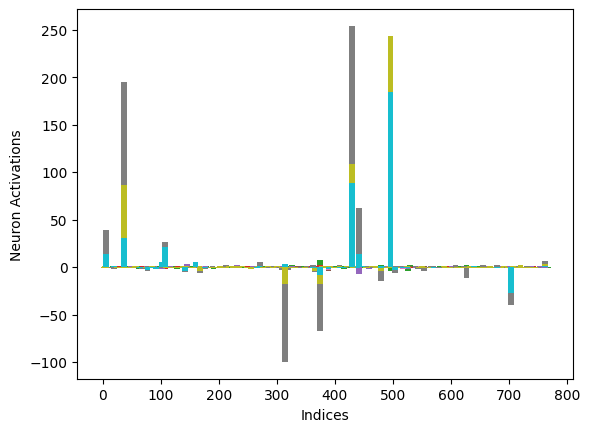

In [111]:
import matplotlib.pyplot as plt

for act in activations[:10]:
    actNormed = model.transformer.ln_f(act).detach().numpy()
    # layerNorm = torch.nn.LayerNorm(act.size(-1), elementwise_affine=False).to(device).eval()
    # actNormed = layerNorm(act).cpu().detach().numpy()
    # print(torch.allclose(act, actNormed)) #<- Outputs False, so layerNorm *should* be doing something
    
    
    (neuronActivations, indices) = zip(*enumerate(actNormed))
    plt.bar(range(len(act)), act, width=10)
plt.xlabel("Indices")
plt.ylabel("Neuron Activations")
plt.show()
# What's happening around neurons 400-500 and ~300???

In [ ]:
# Building the magic to make sense of the interesting bits
class SAE(nn.Module):
    def __init__(self, inDims, codeDims, tied=False, topk=None):
        super().__init__()
        self.encoder = nn.Linear(inDims, codeDims, bias=True) # Bias is true because it's good at learning activation offsets
        self.decoder = nn.Linear(codeDims, inDims, bias=False) # Bias is false because we want representations to be just combinations of feature directions
        # Note: If we had bias true, some feature vectors could be offset by an arbitrary amount,
        # making it harder to compare veature vectors in some situations
        self.tied = tied # True can help improve improve how identifiable features are, constrains the solution
        self.topk = topk # Hard sparsity - keeps only largest k activations - used for fixed amount of active features
        if tied:
            self.decoder.weight = self.encoder.weight

    def encode(self, x):
        # x is the hidden layer we're passing in
        s = self.encoder(x)
        if self.topk is not None:
            # k = self.topk
            # Grab the top k values and their dimensions
            topkVals, topkIndex = torch.topk(s, self.topk, dim=-1)
            # Make a mask out of them 
            mask = torch.zeros_like(s).scatter_(-1, topkIndex, 1.0)
            # Multiply the mask in and kill any features that aren't within the {self.topk} dimensions
            # Works as a "hard sparsity"
            s = s * mask
            s = torchFun.relu(s)
        else:
            # Relies on L1 penalty in loss - "soft sparsity"
            s = torchFun.relu(s)
        return s
    
    def forward(self, x):
        s = self.encode(x)
        xHat = self.decoder(s)
        return xHat, s

In [ ]:
# SAE training function
import tqdm

def train_sae(X, codeDims=4*modelDims, l1=1e-3, epochs=5, batchSize=256, topk=None, learningRate=1e-3, tied=False):
    sae = SAE(inDims=modelDims, codeDims=codeDims, tied=tied, topk=topk).to(device)
    optimizer = torch.optim.Adam(sae.parameters(), lr=learningRate)

    dataset = torch.utils.data.TensorDataset(X) # X is CPU tensor
    dataLoader = DataLoader(dataset, batch_size=batchSize, shuffle=True, drop_last=True)


    for ep in tqdm(range(epochs)):
        losses, reconstructionLosses, l1_losses = [], [], []
        for (batchActivations,) in dataLoader:
            batchActivations = batchActivations.to(device)
            xhat, s = sae(batchActivations)
            reconstructionLoss = torchFun.mse_loss(xhat, batchActivations)
            l1Penalty = s.abs().mean()
            loss = reconstructionLoss + l1 * l1Penalty

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            reconstructionLosses.append(reconstructionLoss.item())
            l1_losses.append(l1Penalty.item())
        t.set_description(f"ep {ep}: loss {sum(losses)/len(losses):.4f} | recon {sum(recon_losses)/len(recon_losses):.4f} | L1 {sum(l1_losses)/len(l1_losses):.4f}")
        t.refresh()
    
    return sae.eval()
        

In [ ]:
# A helpful function to get the topk features
# This is what maximally activates features

@torch.no_grad()
def get_feature_topk(sae, X, k=20, batch=1024):
    indexes = []
    allScores = []
    for i in range(0, X.size(0), batch):
        batchActivations = X[i:i+batch].to(device) # xb is a batch of activations
        _, s = sae(batchActivations) # s is sparse code
        allScores.append(s.detach().cpu())
    scores = torch.cat(allScores, dim=0)

    for j in range(scores.size(1)):
        vals, topIndex = torch.topk(scores[:, j], k)
        indexes.append(topIndex)
    return indexes, scores

In [ ]:
# Feature steering
# Lets us push features in directions (small + 1 = medium + 1 = large)
# Shows that a direction has meaning

@torch.no_grad()
def steer_with_feature(model, tokenizer, prompt, sae, featureId, epsilon=0.5):
    # Run a pass through the LM
    encoder = tokenizer(prompt, return_tensors="pt").to(device)
    out = model(**encoder, output_hidden_states=True)
    H = out.hidden_states[-1][:, -1, :]

    # Run a pass through the SAE with the LM's hidden states
    _, s = sae(H)
    d = sae.decoder.weight[featureId]

    # Steer the SAE's outputs in a direction
    H_steered = H + epsilon * d

    # Pass the logits back out for analysis
    logits = model.lm_head(H)
    logits_steered = model.lm_head(H_steered)
    return logits.squeeze(0), logits_steered.squeeze(0)



In [ ]:
# Stability across restarts
@torch.no_grad()
def match_features_by_cosine(D1, D2):
    # D1, D2: (d_code, d_model) row-major weights
    #Normalize rows
    D1n = torchFun.normalize(D1, dim1)
    D2n = torchFun.normalize(D2, dim1)
    sim = D1n @ D2n.T

    # Basic argmax
    row_best = sim.max(dim=1).values.mean().item()
    col_best = sim.max(dim=0).values.mean().item()
    return sim, row_best, col_best

In [ ]:
# Some helper functions for analysis
@torch.no_grad()
def eval_reconstruction_stats(sae, Xeval, batch=2048):
  reconstructionSum, elements = 0.0, 0
  allScores = []
  for i in range(0, Xeval, batch):
    xb = Xeval[i:i+batch].to(device)
    xhat, score = sae(xb)
    # Calculate the mean squared error of the model over the evaluation ds
    reconstructionSum += torchFun.mse_loss(xhat, xb, reduction='sum').item()
    elements += xb.numel()
    allScores.append(score.detach().cpu())
  mse = reconstructionSum / elements
  variance = Xeval.pow(2).mean().item()
  r2 = max(0.0, 1.0 - mse / (variance + 1e-12))
  score = torch.cat(allScores, dim=0)
  return mse, r2, score

@torch.no_grad()
def calc_sparsity_metrics(S):
  density = (S > 0).float().mean().item()
  deadRate = ()